In [1]:
import sys
sys.path.insert(0, '/data/schoiaj/repos/nli_explain')
import json

import pandas as pd

from explainers.archipelago.viz.text import viz_text
from utils.data_utils import get_clean_token_list
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [103]:
from explainers.archipelago.get_explainer import ArchExplainerInterface

arch = ArchExplainerInterface('bert-base',
                        device='cuda',
                        explainer_class='arch')
cross_arch = ArchExplainerInterface('bert-base',
                        device='cuda',
                        explainer_class='cross_arch')

In [2]:
df = pd.read_csv('../data/e-SNLI/esnli_test_processed_1k.csv')

In [70]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
def analyze_explanation(df, explanation, idx, topk=1, texts=None, gold_label=None):
    
    
    if texts is None:
        texts = df.iloc[idx][['Sentence1', 'Sentence2']].tolist()
    cleaned_premise = [w.lower() for w in get_clean_token_list(texts[0])]
    cleaned_hypothesis = [w.lower() for w in get_clean_token_list(texts[1])]

    tokens = cleaned_premise + ['->'] + cleaned_hypothesis
    if gold_label is None:
        gold_label = df.iloc[idx]['gold_label']
    print("texts:", texts)
    print("gold label:", gold_label)
    print("pred label:", explanation[idx]['pred_label'])
    print("explanations:", explanation[idx]['pred_rationales'])
    print("interactions_vote:", df.iloc[idx]['interactions_vote'])
    print("interactions_union:", df.iloc[idx]['interactions_union'])
    
    explanation_idx = {}

    for i, interaction in enumerate(explanation[idx]['pred_rationales'][:topk]):
        indices = []
        tok_idx = -1
        for pre_token in interaction[0]:
            if pre_token not in cleaned_premise[tok_idx + 1:]:
                continue
            tok_idx = tok_idx + 1 + cleaned_premise[tok_idx + 1:].index(pre_token)
            indices.append(tok_idx)
        tok_idx = -1
        for hyp_token in interaction[1]:
            if hyp_token not in cleaned_hypothesis[tok_idx + 1:]:
                continue
            tok_idx = tok_idx + 1 + cleaned_hypothesis[tok_idx + 1:].index(hyp_token)
            indices.append(tok_idx + len(cleaned_premise) + 1)
        if indices:
            explanation_idx[tuple(indices)] = len(explanation[idx]['pred_rationales']) - i
        
    for i in range(len(tokens)):
        explanation_idx[(i,)] = 0
        
    fig = viz_text(explanation_idx, tokens, title='asdf')
    display(fig)
    plt.close()

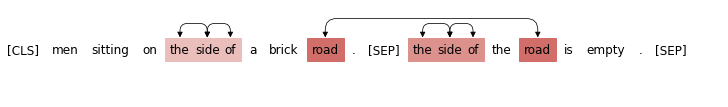

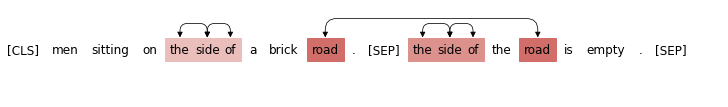

In [106]:
explanation, tokens, pred = cross_arch.explain(*df.iloc[380][['Sentence1', 'Sentence2']].tolist())

for i in range(len(tokens)):
    explanation[(i,)] = 0

viz_text(explanation, tokens)

high-order

bert-base_arch-5_10_test_BT=[MASK]_interaction.json
texts: ['Man is shaving in the mirror.', "The man's beard is quite long."]
gold label: neutral
pred label: neutral
explanations: [[[], ["'", 's', 'beard', 'quite', 'long']]]
interactions_vote: []
interactions_union: []


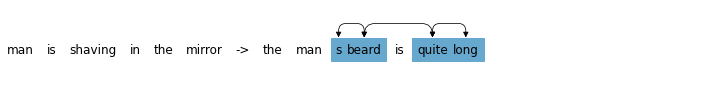


bert-base_cross_arch-5_10_test_BT=[MASK]_interaction.json
texts: ['Man is shaving in the mirror.', "The man's beard is quite long."]
gold label: neutral
pred label: neutral
explanations: [[[], ["'", 's', 'beard', 'quite', 'long']]]
interactions_vote: []
interactions_union: []


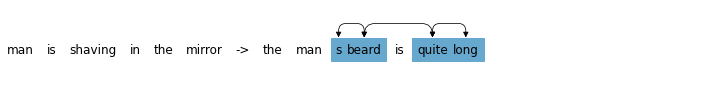


bert-base_cross_arch-5_10_test_BT=[MASK]_interaction_X.json
texts: ['Man is shaving in the mirror.', "The man's beard is quite long."]
gold label: neutral
pred label: neutral
explanations: [[['shaving'], ['quite']], [['man'], ["'"]], [['in'], ['beard']], [['mirror'], ['s']], [['shaving'], ['beard']]]
interactions_vote: []
interactions_union: []


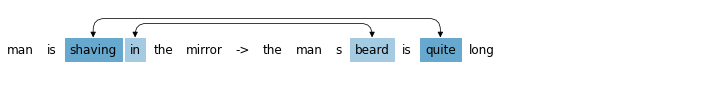


bert-base_mask_explain-3-p0.5-n10000-inv0_10_test_BT=attention+[MASK]_interaction.json
texts: ['Man is shaving in the mirror.', "The man's beard is quite long."]
gold label: neutral
pred label: neutral
explanations: [[['man'], ['man', 'long']], [['man'], ['is', 'long']], [['man'], ['the', 'long']], [['shaving'], ['the', 'long']], [['the'], ['the', 'long']], [['man'], ['quite', 'long']], [['shaving'], ['man', 'long']], [['man'], ['s', 'long']], [['shaving'], ['is', 'long']]]
interactions_vote: []
interactions_union: []


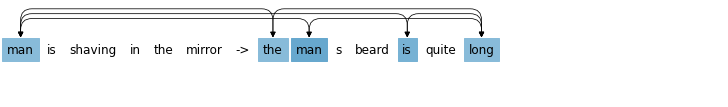


bert-base_mask_explain-2,3-p0.5-n10000-inv0_10_test_BT=attention+[MASK]_interaction.json
texts: ['Man is shaving in the mirror.', "The man's beard is quite long."]
gold label: neutral
pred label: neutral
explanations: [[['man'], ['man', 'long']], [['man'], ['the', 'long']], [['man'], ['is', 'long']], [['shaving'], ['the', 'long']], [['the'], ['the', 'long']], [['man'], ['s', 'long']], [['shaving'], ['is', 'long']], [['man'], ['quite', 'long']], [['is'], ['the', 'long']]]
interactions_vote: []
interactions_union: []


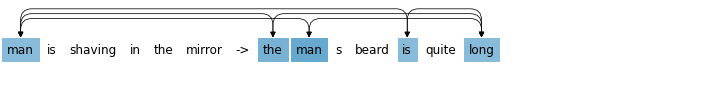

In [125]:
# failure
# idx = 929  # entail
# idx = 305  # contradict
# idx = 274  # contra
# idx = 267  # entail
# idx = 194  # contra  model is wrong, and the explanations are weird
# idx = 909  # contra  (counting)
# idx = 77  # voice (passive active)

# all success
# idx = 270  # contradict
# idx = 84  # entail
# idx = 532  # entail, copy paste
# idx = 640  # neutral, more or less copy paste

# my success
# idx = 283  # entail  (good example)
# idx = 137  # contra  (not rlly success, just difference)
# idx = 109  # contra  (kinda?)
# idx = 179  # entail  (kinda?)  (but the model was wrong)
# idx = 757  # contra  (the model was wrong, but the rationale make the most sense)
# idx = 768  # neutral (less noisy)
# my fail
# idx = 134 # entail
# idx = 45  # entail

idx = 771
idx = 253
idx = 96
idx = 483
idx = 139
idx = 72
# pairwise
# print('pairwise')
# exp_files = ['bert-base_arch_pair-5_10_test_BT=[MASK]_interaction.json',
#              'bert-base_cross_arch_pair-5_10_test_BT=[MASK]_interaction.json',
#              'bert-base_naive_occlusion_10_test_BT=[MASK]_interaction.json',
#              'bert-base_IH_10_test_BT=[MASK]_interaction.json',
#              'bert-base_mask_explain-2-p0.5-n10000-inv0_10_test_BT=attention+[MASK]_interaction.json',
#              ]


print('high-order')
exp_files = ['bert-base_arch-5_10_test_BT=[MASK]_interaction.json',
             'bert-base_cross_arch-5_10_test_BT=[MASK]_interaction.json',
             'bert-base_cross_arch-5_10_test_BT=[MASK]_interaction_X.json',
             'bert-base_mask_explain-3-p0.5-n10000-inv0_10_test_BT=attention+[MASK]_interaction.json',
             'bert-base_mask_explain-2,3-p0.5-n10000-inv0_10_test_BT=attention+[MASK]_interaction.json',
            #  'bert-base_mask_explain-4-p0.5-n10000-inv0_10_test_BT=attention+[MASK]_interaction.json',
             ]
for exp_file in exp_files:
    print()
    print(exp_file)
    with open(f'../explanations/{exp_file}', 'r') as f:
        explanations = json.load(f)

    analyze_explanation(df, explanations, idx, topk=3)

In [110]:
pd.set_option('display.max_colwidth', None)
df[df['gold_label'] == 'neutral'][['Sentence1', 'Sentence2', 'gold_label']].sample(50)

,Sentence1,Sentence2,gold_label
582,"Two basketball players on opposing teams, one in white, the other in red, are mid-game, running down the court, white-uniform player with ball-in-hand.",The white team is winning a basketball game.,neutral
573,Four men and a young boy are at a table set up for wood crafts.,The group of men are teaching the boy how to make wood crafts.,neutral
939,"Three men in yellow green safety vests sit on a bench yawning, smoking and having a break.",Some guys are taking a rest from working.,neutral
73,Asian people about to perform animal balloons.,people perform for kids,neutral
917,Three military officials are battling a fire my a building.,Three military offcials battle a fire after an accidental explosion.,neutral
952,Two men work outside polishing shoes.,Some men are polishing the shoes of business men.,neutral
722,A dog with a collar on lying on the street.,The dog was just hit by a car and is lying in the street.,neutral
668,A mother shading her baby with an umbrella as she and her partner climb the stairs.,A young woman holds a red umbrella over her infant son as she goes upstairs.,neutral
58,A cheerleader in a tight red and white uniform is passing out white t-shirts at a sporting event.,A cheerleader passes out team shirts,neutral
140,A lady in a dark coat is sitting with many people around her.,A woman is attempting an eating competition at a festival.,neutral


In [88]:
eval_df = pd.read_csv('../eval_results/bert-base_mask_explain-3-p0.5-n10000-inv0_10_interaction_f1_test_union_10_BT=attention+[MASK]_skip-neutral_only-correct_all.csv')

In [89]:
eval_df

,interaction_f1_top1,interaction_f1_top2,interaction_f1_top3,interaction_f1_top4,interaction_f1_top5,interaction_f1_top6,interaction_f1_top7,interaction_f1_top8,interaction_f1_top9,interaction_f1_top10
0,0.333333,0.566667,0.488889,0.450000,0.426667,0.411111,0.400000,0.391667,0.385185,0.386667
1,0.000000,0.133333,0.177778,0.200000,0.160000,0.177778,0.171429,0.150000,0.133333,0.133333
2,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
3,1.000000,0.750000,0.666667,0.625000,0.588889,0.564815,0.555556,0.541667,0.530864,0.530864
4,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
...,...,...,...,...,...,...,...,...,...,...
608,0.266667,0.258333,0.255556,0.254167,0.253333,0.294444,0.328571,0.318750,0.320370,0.320370
609,0.190476,0.095238,0.137566,0.103175,0.082540,0.068783,0.058957,0.051587,0.045855,0.041270
610,0.163265,0.163265,0.164399,0.164116,0.147619,0.150227,0.152575,0.143707,0.136810,0.136810
611,0.266667,0.266667,0.266667,0.366667,0.360000,0.322222,0.295238,0.291667,0.274074,0.313333


In [93]:
eval_df['interaction_f1_top2'].sort_values(ascending=False)

328    0.80
437    0.75
453    0.75
404    0.75
115    0.75
       ... 
300    0.00
301    0.00
577    0.00
578    0.00
295    0.00
Name: interaction_f1_top2, Length: 613, dtype: float64